In [ ]:
"""
El objetivo es analizar la atribución multicanal de campañas de marketing para optimizar el media mix.
Cliente objetivo:
- Equipos de marketing
- Analistas de medios
- Ejecutivos de negocio
Output:
- Contribution de cada canal
- Simulación de escenarios de inversión
- Insights para optimizar ROI
"""

In [ ]:
# !pip install statsmodels

   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.5 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.5 MB 2.0 MB/s eta 0:00:05
   ---------------- ----------------------- 3.9/9.5 MB 9.9 MB/s eta 0:00:01
   ----------------------------- ---------- 7.1/9.5 MB 11.8 MB/s eta 0:00:01
   ---------------------------------------- 9.5/9.5 MB 12.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


In [ ]:
DATA_RAW = Path("../data/raw")
users = pd.read_csv(DATA_RAW / "users.csv")
events = pd.read_csv(DATA_RAW / "events.csv")
transactions = pd.read_csv(DATA_RAW / "transaction_items.csv")
products = pd.read_csv(DATA_RAW / "products.csv")
marketing = pd.read_csv(DATA_RAW / "uplift_marketing.csv")  # Datos de campañas: canal, inversión, fecha


In [11]:
# Ver las columnas y algunas filas
print("Columnas disponibles en marketing:")
print(marketing.columns.tolist())
display(marketing.head())

Columnas disponibles en marketing:
['user_id', 'grupo', 'prob_compra_previa', 'descuento_ofrecido', 'engagement_score', 'historial_compras', 'compra']


,user_id,grupo,prob_compra_previa,descuento_ofrecido,engagement_score,historial_compras,compra
0,1,control,0.105,5,0.335,4,0
1,2,control,0.371,15,0.714,9,0
2,3,tratamiento,0.226,10,0.963,1,0
3,4,tratamiento,0.068,5,0.346,1,0
4,5,tratamiento,0.073,10,0.486,3,1


In [ ]:

#  Filtrar eventos de compra

events_purchase = events[events["event_type"] == "purchase"]


#nMerge para obtener precio

sales_data = events_purchase.merge(
    products[["product_id", "price"]],
    on="product_id",
    how="left"
)
# Revenue
if "quantity" in sales_data.columns:
    sales_data["revenue"] = sales_data["quantity"] * sales_data["price"]
else:
    sales_data["revenue"] = sales_data["price"]

sales_data["date"] = pd.to_datetime(sales_data["timestamp"]).dt.date

# Agrupar ventas por día

sales_daily = sales_data.groupby("date")["revenue"].sum().reset_index()
sales_daily = sales_daily.sort_values("date").reset_index(drop=True)


# datos de marketing a nivel usuario
sales_by_user = sales_data.groupby("user_id")["revenue"].sum().reset_index()

# Merge con marketing
mmm_df = sales_by_user.merge(
    marketing,
    on="user_id",
    how="left"
)


# ejemplo

print("Shape del dataframe de MMM:", mmm_df.shape)
display(mmm_df.head(10))

Shape del dataframe de MMM: (22663, 8)


,user_id,revenue,grupo,prob_compra_previa,descuento_ofrecido,engagement_score,historial_compras,compra
0,1,433.44,control,0.105,5,0.335,4,0
1,3,355.59,tratamiento,0.226,10,0.963,1,0
2,7,259.46,tratamiento,0.368,5,0.001,14,0
3,8,283.33,tratamiento,0.333,0,0.753,2,1
4,9,945.93,control,0.244,0,0.125,0,1
5,18,166.83,control,0.372,0,0.474,1,1
6,19,254.70,tratamiento,0.338,15,0.728,2,1
7,22,116.19,control,0.040,0,0.931,6,0
8,23,454.58,tratamiento,0.292,10,0.938,7,1
9,28,449.87,control,0.112,10,0.495,4,0


In [ ]:

# MMM (Regresión lineal)
import statsmodels.api as sm


#features

features = ["prob_compra_previa", "descuento_ofrecido", "engagement_score", "historial_compras"]

X = mmm_df[features]
y = mmm_df["revenue"]


# constante de regresión

X = sm.add_constant(X)

# OLS
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9533
Date:                Thu, 15 Jan 2026   Prob (F-statistic):              0.432
Time:                        23:54:03   Log-Likelihood:            -1.5480e+05
No. Observations:               22663   AIC:                         3.096e+05
Df Residuals:                   22658   BIC:                         3.096e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                337.7320      5

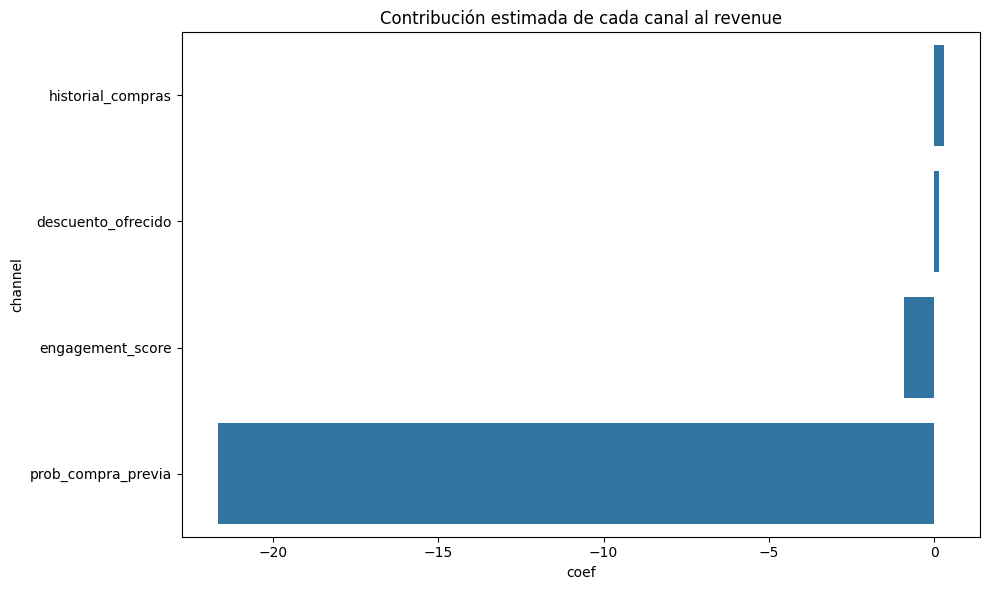

In [ ]:
# visualización
# Coeficientes de contribución de cada canal
contributions = pd.DataFrame({
    "channel": X.columns[1:],  # excluir la constante
    "coef": model.params[1:]
}).sort_values(by="coef", ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="coef", y="channel", data=contributions)
plt.title("Contribución estimada de cada canal al revenue")
plt.tight_layout()
plt.show()


In [ ]:
# MMM Mejorado con agregación diaria por grupo
import pandas as pd
import numpy as np
import statsmodels.api as sm


# solo los eventos de compra
events_purchase = events[events["event_type"] == "purchase"]

# Merge con productos para obtener precio

sales_data = events_purchase.merge(
    products[["product_id", "price"]],
    on="product_id",
    how="left"
)


# revenue

if "quantity" in sales_data.columns:
    sales_data["revenue"] = sales_data["quantity"] * sales_data["price"]
else:
    sales_data["revenue"] = sales_data["price"]

sales_data["date"] = pd.to_datetime(sales_data["timestamp"])  # datetime64[ns]
sales_daily_user = sales_data.groupby(["date","user_id"])["revenue"].sum().reset_index()

# marketing  merge

marketing = pd.read_csv(DATA_RAW / "uplift_marketing.csv")

# Generar columna date si no existe
if "date" not in marketing.columns:
    min_date = sales_data["date"].min()
    max_date = sales_data["date"].max()
    np.random.seed(42)
    marketing["date"] = np.random.choice(pd.date_range(min_date, max_date), size=len(marketing))

# Convertir marketing["date"] a datetime64[ns]
marketing["date"] = pd.to_datetime(marketing["date"])

# Merge ventas y marketing 
mmm_user = pd.merge(
    sales_daily_user,
    marketing,
    left_on=["date","user_id"],
    right_on=["date","user_id"],
    how="left"
).fillna(0)

# Agregar por día y grupo
mmm_df = mmm_user.groupby(["date","grupo"]).agg({
    "revenue": "sum",
    "prob_compra_previa": "mean",
    "descuento_ofrecido": "mean",
    "engagement_score": "mean",
    "historial_compras": "mean"
}).reset_index()


# Convertir grupo  y definir X, y

mmm_df = pd.get_dummies(mmm_df, columns=["grupo"], drop_first=True)
X = mmm_df.drop(columns=["date","revenue"])
y = mmm_df["revenue"]

# Agregar constante
X = sm.add_constant(X)


# OLS
model = sm.OLS(y, X).fit()
print(model.summary())



                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 15 Jan 2026   Prob (F-statistic):                nan
Time:                        23:58:28   Log-Likelihood:            -1.8825e+05
No. Observations:               29232   AIC:                         3.765e+05
Df Residuals:                   29231   BIC:                         3.765e+05
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                260.4694      0

C:\Users\Gloria Rodríguez\AppData\Local\Temp\ipykernel_27448\1429418298.py:64: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)
c:\Users\Gloria Rodríguez\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [18]:
print(mmm_df[["prob_compra_previa", "descuento_ofrecido", "engagement_score", "historial_compras"]].nunique())


prob_compra_previa    1
descuento_ofrecido    1
engagement_score      1
historial_compras     1
dtype: int64


In [19]:
print(mmm_df[["prob_compra_previa", "descuento_ofrecido", "engagement_score", "historial_compras"]].corr())


                    prob_compra_previa  descuento_ofrecido  engagement_score  \
prob_compra_previa                 NaN                 NaN               NaN   
descuento_ofrecido                 NaN                 NaN               NaN   
engagement_score                   NaN                 NaN               NaN   
historial_compras                  NaN                 NaN               NaN   

                    historial_compras  
prob_compra_previa                NaN  
descuento_ofrecido                NaN  
engagement_score                  NaN  
historial_compras                 NaN  


In [ ]:
# =========================
# 5️⃣ Escenarios de inversión
# =========================
# Supongamos un incremento del 10% en cada canal
scenario = X.copy()
for col in X.columns[1:]:
    scenario[col] = scenario[col] * 1.10

scenario["predicted_revenue"] = model.predict(scenario)
print("Revenue estimado con +10% inversión por canal:", scenario["predicted_revenue"].sum())